# DAG для продукта: ETL, отчёт и алерты.

## Продукт
Продукт состоит из двух больших частей - лента новостей и мессенджер, которые хранятся в двух таблицах. Соответсвенно, аудитория этих двух функционалов не совсем совпадает и сами метрики разные. 
## ETL
**Результат - DAG в airflow, который:**
- Выгружает сагрегированные данные из двух таблиц за предыдущий день с помощью pandahouse
- Нас интересуют все пользователи обоих сервисов, и даг рассчитывает метрики по срезами с учётом всех пользователей из обеих таблиц. Для этого он объединяет таблицы и считает метрики в разрезе: пол, возраст и ос
- Финальные данные со всеми метриками записывает в отдельную таблицу в ClickHouse
- Каждый день добавляет новые данные в таблицу в CH. Например, 08.09 таблица пополнится данными по метрикам за 07.09 

**Структура финальной таблицы:**

Дата - event_date

Название среза - dimension

Значение среза - dimension_value

Число просмотров - views

Числой лайков - likes

Число полученных сообщений - messages_received

Число отправленных сообщений - messages_sent

От скольких пользователей получили сообщения - users_received

Скольким пользователям отправили сообщение - users_sent

Срез - это os, gender и age

*Скрин того, как финальная таблица выглядит в CH:*
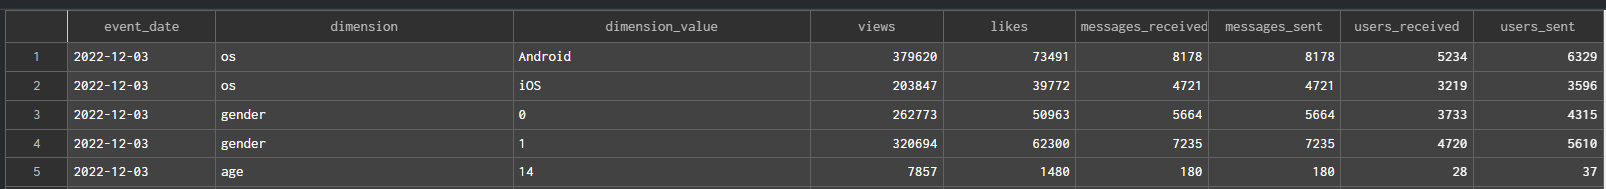

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import pandahouse
import requests

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context


# Соединение с CH
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'k.bataeva',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=1),
    'start_date': datetime(2022, 12, 3),
}

# Интервал запуска DAG
schedule_interval = '05 0 * * *'

@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def dag_metrics_to_ch():
    
    #таск для выгрузки данных из фида
    @task()
    def extract_feed():
        q = """
        SELECT
          today() - 1 AS event_date,
          user_id,
          age,
          os,
          gender,
          sum(action == 'view') as views,
          sum(action == 'like') as likes
        FROM
          simulator_20221120.feed_actions
        WHERE
          toDate(time) = today() - 1
        GROUP BY
          age,
          gender,
          os,
          age,
          user_id
        """

        df_feed = pandahouse.read_clickhouse(q, connection=connection)
        
        return df_feed
    
    
    #таск для выгрузки данных из сообщений
    @task
    def extract_msg():
        q = """
        SELECT *, today() - 1 AS event_date

        FROM

        (SELECT
          gender,
          os,
          age,
          user_id,
          COUNT(*) as messages_sent,
          COUNT (DISTINCT reciever_id) as users_sent

        FROM
          simulator_20221120.message_actions
            WHERE
          toDate(time) = today() - 1 
        GROUP BY
          gender,
          os,
          age,
          user_id)  AS sent_tbl

        FULL OUTER JOIN

        (SELECT 
          gender,
          os,
          age,
          COUNT(*) as messages_received,
          COUNT (DISTINCT user_id) as users_received,
          reciever_id AS user_id  
        FROM
          simulator_20221120.message_actions
          WHERE
          toDate(time) = today() - 1
        GROUP BY
          gender,
          os,
          age,
          user_id) AS rec_tbl 

                USING(user_id, os, gender, age)
        ORDER BY user_id  
        """

        # Вытащили пользователей
        df_msg = pandahouse.read_clickhouse(q, connection=connection)
        
        return df_msg

    #объединяю дф
    @task
    def merge_tables(df_feed, df_msg):
        
        df_full = df_feed.merge(df_msg, how = 'outer')
        
        return df_full
    
    #метрики по срезу os
    @task    
    def get_os(df_full):
        
        df = df_full[['os','views', 'likes', 'messages_received', 'messages_sent','users_received','users_sent']].groupby('os', as_index = False).sum()

        df.rename(columns = {'os':'dimension_value'}, inplace = 'True')
        df['event_date'] = df_full.event_date
        df['dimension'] = 'os'
        
        cols = df.columns.to_list()
        cols = cols[-2:] + cols[:-2]
        df = df[cols]
        
        return df
    
    #метрики по срезу gender   
    @task 
    def get_gender(df_full): 
        
        df = df_full[['gender','views', 'likes', 'messages_received', 'messages_sent','users_received','users_sent']].groupby('gender', as_index = False).sum()

        df.rename(columns = {'gender':'dimension_value'}, inplace = 'True')
        df['event_date'] = df_full.event_date
        df['dimension'] = 'gender'
        
        cols = df.columns.to_list()
        cols = cols[-2:] + cols[:-2]
        df = df[cols]
        return df    
    
    #метрики по срезу age    
    @task 
    def get_age(df_full):    

        df = df_full[['age','views', 'likes', 'messages_received', 'messages_sent','users_received','users_sent']].groupby('age', as_index = False).sum()

        df.rename(columns = {'age':'dimension_value'}, inplace = 'True')
        df['event_date'] = df_full.event_date
        df['dimension'] = 'age'
        cols = df.columns.to_list()
        cols = cols[-2:] + cols[:-2]
        df = df[cols]
        return df
    
    #загрузка в CH
    @task
    def load_to_CH(df_os, df_gender, df_age):
        
        #контекст дага
        context = get_current_context()
        ds = context['ds']
        
        #обединяю срезы, задаю нужные типы
        df_to_CH = pd.concat([df_os, df_gender, df_age])
        df_to_CH.iloc[:, 3:] = df_to_CH.iloc[:, 3:].astype(int) 
        
        #коннект с кликом
        connection_add_to_table = {'host': 'https://clickhouse.lab.karpov.courses',
                                   'database':'test',
                                   'user':'student-rw',
                                   'password':'656e2b0c9c'
                                   }
        
        #загружаю
        pandahouse.to_clickhouse(df_to_CH,'bataeva_CH',index=False, connection=connection_add_to_table)        
        
        
    df_feed = extract_feed()
    df_msg = extract_msg()
    
    df_full = merge_tables(df_feed, df_msg)
    
    df_os = get_os(df_full)
    df_gender = get_gender(df_full)
    df_age = get_age(df_full)
    
    load_to_CH(df_os, df_gender, df_age)

dag_metrics_to_ch = dag_metrics_to_ch()

## Report

Единый отчет о работе всего приложения с помощью telegram и airflow, каждый день бот отправляет информацию по метрикам за предыдущий день в текстовом виде и с графиками. Графики отражают поведение метрики за последнюю неделю.

Пример сообщения от бота:
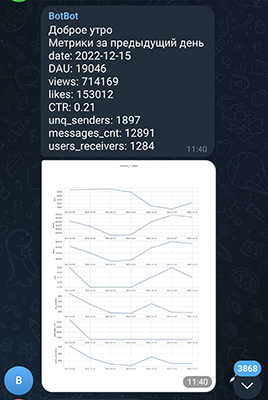

In [2]:
import telegram
import pandas as pd
import matplotlib.pyplot as plt
import pandahouse
import io
import seaborn as sns

from datetime import datetime, timedelta

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

# Соединение с CH
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'k.bataeva',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=1),
    'start_date': datetime(2022, 12, 3),
}


# Интервал запуска DAG
schedule_interval = '00 11 * * *' 

@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def dag_metrics_fm_to_tg():
    

    @task()
    def get_and_send_metrics():
        
        # стили графиков
        sns.set (
            font_scale =1,
            style = 'whitegrid',
            rc= {'figure.figsize': (10,7)}
        )


        # инфа о тг канале
        my_token = '000' 
        bot = telegram.Bot(token=my_token) 
        chat_id=000 

        #метрики новостной ленты
        q_feed_actions = """
          SELECT
          toDate(time) as date,
          COUNT (DISTINCT user_id) as DAU,
          countIf(action = 'view') as views,
          countIf(action = 'like') as likes,
          ROUND((countIf(action = 'like')  / countIf(action = 'view')), 2) as CTR  
        FROM
          simulator_20221120.feed_actions
        WHERE
          toDate(time) >= (today() - 7) AND toDate(time) < today() 

        group by date
        """        
        
        
        #метрики сообщений    
        q_message_actions= """
        SELECT
          toDate(time) AS date,
          COUNT (DISTINCT user_id) AS unq_senders,
          COUNT(*) as messages_cnt,
          COUNT (DISTINCT reciever_id) as users_receivers
        FROM
          simulator_20221120.message_actions
        WHERE
          toDate(time) >= (today() - 7)
          AND toDate(time) < today()
        group by
          date
        """
        df_q_feed_actions = pandahouse.read_clickhouse(q_feed_actions, connection=connection)
        df_q_message_actions =  pandahouse.read_clickhouse(q_message_actions, connection=connection)
        
        
        #объединяю датафреймы
        metrics_7_days = df_q_feed_actions.merge(df_q_message_actions, on = 'date')
        metrics_7_days.date = metrics_7_days.date.astype(str).values # перевожу в стр, чтобы не было проблем с отображением
        
        #отдельная переменная для вчерашнего дня
        metrics_last_day = metrics_7_days.tail(1)
     
        # подготавливаю график
        fig, axs = plt.subplots(nrows=len(metrics_last_day.columns) - 1, figsize = (15,20))
        plt.set_loglevel('WARNING')
        i = 0 
        for col in metrics_7_days.columns[1:]:
            sns.lineplot(data = metrics_7_days, x = 'date', linewidth = 2, y = metrics_7_days[col],  ax = axs[i]) 
            axs[i].set(xlabel='')
            i = i+1
            
        fig.suptitle('metrics_7_days') 

        
        # подготавливаю сообщение
        msg = """Доброе утро 
Метрики за предыдущий день
"""
        for column in metrics_last_day.columns:
            msg = msg + column+ ': '+ str(metrics_last_day[column].values[0])
            msg = msg+'\n'
            
            
        # отправляю сообщение
        bot.sendMessage(chat_id=chat_id, text=msg)
                       
        # отправляю график
        plot_object = io.BytesIO()
        plt.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = 'metrics_7_days.png'
        plt.close()
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)
        
    
                       
                       
    get_and_send_metrics()


dag_metrics_fm_to_tg = dag_metrics_fm_to_tg()

## Alert

Алерты нужны, чтобы срочно сообщать о проседании метрик. 
- Даг запускается каждые 15 минут, и оценивает состояние последней полной пятнадцатиминутки относительно пяти предыдущих. Период был выбран на основании поведения продукта
- Как понять, что метрика опустилась/поднялась выше нормы? Для обнаружения аномалии использовались доверительные интервалы, рассчитаные через межквартильный размах на основании пяти предыдущих наблюдений(сглаженные значения 0.25 и 0.75 квантилей)
- В случае обнаружения аномалии бот отправляет в чат сообщение с метрикой, значением её отклонения от предыдущей пятнадцатиминутки и графиком её поведения за последние сутки, а также ссылкой на дашборд

Пример сообщения в тг: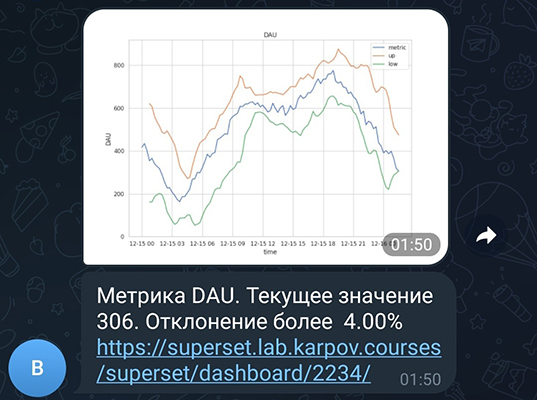

In [3]:
import telegram
import pandas as pd
import matplotlib.pyplot as plt
import pandahouse
import io
import seaborn as sns

from datetime import datetime, timedelta

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

# Соединение с CH
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'k.bataeva',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=1),
    'start_date': datetime(2022, 12, 3),
}


# Интервал запуска DAG
schedule_interval = '*/15 * * * *' 

@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def dag_alert_kbataeva():
    
    @task()
    def alert_check_and_send():
    
        my_token = '000' # тут нужно заменить на токен вашего бота
        bot = telegram.Bot(token = my_token) # получаем доступ
        chat_id = 000 #чат айди

        # стили графиков
        sns.set (
            font_scale = 1,
            style = 'whitegrid',
            rc= {'figure.figsize': (10,7)}
                )

        q = """
                  SELECT
                  toDate(time) as date,
                  toStartOfFifteenMinutes(time) as ts,
                  formatDateTime(ts, '%R') as hm,
                  COUNT (DISTINCT user_id) as DAU,
                  COUNT (DISTINCT post_id) as active_posts,
                  countIf(action = 'view') as views,
                  countIf(action = 'like') as likes,
                  ROUND((countIf(action = 'like')  / countIf(action = 'view')), 2) as CTR  
                FROM
                  simulator_20221120.feed_actions
                WHERE
                  time >= (today() - 1) AND time < toStartOfFifteenMinutes(now()) 

                GROUP BY
                date, ts

                ORDER BY 
                ts
        """
        df = pandahouse.read_clickhouse(q, connection=connection)
        df

        #функция детекции аномалий через межквартильный размах
        def check_anomaly(df_by_metric, metric, a=4, n=5):

            df_by_metric['q25'] = df_by_metric[metric].shift(1).rolling(n).quantile(0.25) #свдиг, чтобы не учитывать текущую пятиминутку
            df_by_metric['q75'] = df_by_metric[metric].shift(1).rolling(n).quantile(0.75)  

            df_by_metric['iqr'] = df_by_metric['q75'] - df_by_metric['q25']
            df_by_metric['up'] = df_by_metric['q75'] + a* df_by_metric['iqr']
            df_by_metric['low'] = df_by_metric['q25'] - a* df_by_metric['iqr']

            #сглаживаю для более точных алертов
            df_by_metric['up'] = df_by_metric['up'].rolling(n, center = True, min_periods = 1).mean()
            df_by_metric['low'] = df_by_metric['low'].rolling(n, center = True, min_periods = 1).mean()

            #условие для алерта
            if (df_by_metric[metric].iloc[-1] < df_by_metric['low'].iloc[-1] \
                or df_by_metric[metric].iloc[-1] > df_by_metric['up'].iloc[-1]) and (df_by_metric['iqr'].iloc[-1] != 0):
                is_alert = 1    
            else: 
                is_alert = 0

            return is_alert, df_by_metric



        metric_list = df.columns[3:]

        for metric in metric_list:

            df_metric = df[['date', 'ts', 'hm', metric]].copy()
            is_alert, df_by_metric = check_anomaly(df_metric, metric)


            if is_alert == 1:

                diff =  (1 - df_by_metric[metric].iloc[-1] / df_by_metric[metric].iloc[-2]).round(2) 
                msg = f' Метрика {metric}. Текущее значение {df_by_metric[metric].iloc[-1]}. Отклонение более {diff: .2%} https://superset.lab.karpov.courses/superset/dashboard/2234/'

                # рисую график
                ax = sns.lineplot(data = df_by_metric, x = 'ts', y = metric, label = 'metric')
                ax = sns.lineplot(data = df_by_metric, x = 'ts', y = 'up', label = 'up')
                ax = sns.lineplot(data = df_by_metric, x = 'ts', y = 'low', label = 'low')

                #чтобы тики не сбились в кучу
                for ind, label in enumerate(ax.get_xticklabels()):

                    if ind % 15 == 0:
                        label.set_visible = True
                    else:
                        label.set_visible = False

                ax.set(xlabel = 'time')
                ax.set(ylabel = metric)

                ax.set_title(metric)
                ax.set(ylim = (0, None))

                # подготовка графика к отправке
                plot_object = io.BytesIO()
                ax.figure.savefig(plot_object)
                plot_object.seek(0)
                plot_object.name = 'alert.png'
                plt.close()

                # отправляю график
                bot.sendPhoto(chat_id=chat_id, photo=plot_object)

                # отправляю сообщение
                bot.sendMessage(chat_id=chat_id, text=msg)            

    alert_check_and_send()


dag_alert_kbataeva = dag_alert_kbataeva()